# MNIST Base Case

## Imports

In [1]:
import random

import numpy as np
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm

from helpers import load_images, load_labels, visualize_image, get_edges, generate_intermediate_edge_labels

## Set Device to GPU

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"We will be using device: {device}")

We will be using device: cuda


## Load Data

In [3]:
# train data
train_images = load_images("./data/train-images-idx3-ubyte/train-images-idx3-ubyte")
train_labels = load_labels("./data/train-labels-idx1-ubyte/train-labels-idx1-ubyte")

train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels,
    test_size=1/6,  # 10k validation
    stratify=train_labels,
    random_state=42  # for reproducibility
)

# test data
test_images = load_images("./data/t10k-images-idx3-ubyte/t10k-images-idx3-ubyte")
test_labels = load_labels("./data/t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte")

In [4]:
print("Train images shape:", train_images.shape)
print("Val images shape:", val_images.shape)
print("Test images shape:", test_images.shape)

Train images shape: (50000, 28, 28)
Val images shape: (10000, 28, 28)
Test images shape: (10000, 28, 28)


## Visualize an image

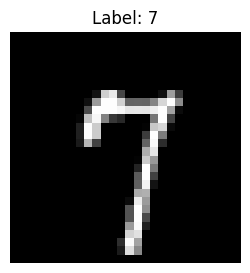

In [5]:
sample_image = train_images[0]
sample_label = train_labels[0]
visualize_image(sample_image, sample_label)

## Convolutions to get Horizontal Edges

### Example Image

In [6]:
horizontal_kernel = np.array([
    [-1, -1, -1],
    [ 0,  0 , 0],
    [ 1,  1,  1],
])

In [7]:
horizontal_edges = get_edges(horizontal_kernel, sample_image)

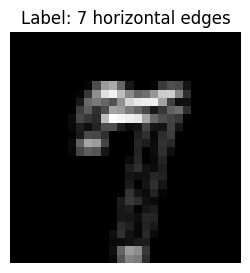

In [8]:
visualize_image(horizontal_edges, f"{sample_label} horizontal edges")

### Extending the Dataset

In [9]:
train_horizontal_image_labels = generate_intermediate_edge_labels(train_images, horizontal_kernel)

In [10]:
val_horizontal_image_labels = generate_intermediate_edge_labels(val_images, horizontal_kernel)

In [11]:
test_horizontal_image_labels = generate_intermediate_edge_labels(test_images, horizontal_kernel)

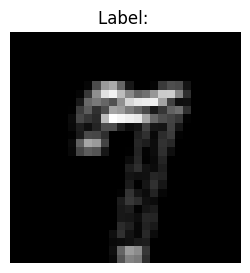

In [12]:
visualize_image(train_horizontal_image_labels[0].reshape(28, 28), "")

## Convolutions to get Vertical Edges

### Example Image

In [13]:
vertical_kernel = np.array([
    [-1,  0,  1],
    [-1,  0,  1],
    [-1,  0,  1],
])

In [14]:
vertical_edges = get_edges(vertical_kernel, sample_image)

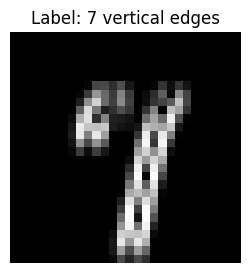

In [15]:
visualize_image(vertical_edges, f"{sample_label} vertical edges")

### Extending the Dataset

In [16]:
train_vertical_image_labels = generate_intermediate_edge_labels(train_images, vertical_kernel)

In [17]:
val_vertical_image_labels = generate_intermediate_edge_labels(val_images, vertical_kernel)

In [18]:
test_vertical_image_labels = generate_intermediate_edge_labels(test_images, vertical_kernel)

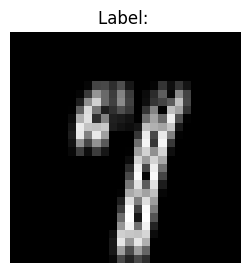

In [19]:
visualize_image(train_vertical_image_labels[0].reshape(28, 28), "")

# Our Test

## Architecture

We keep our two hidden layers at image size to be able to calculate a local loss to push those layers to learn human recognizable structures. However, for the example below, we don't calculate intermediate loss, as we need a basis.

In [20]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        layer_size_by_pixels = 28*28
        
        self.flatten = nn.Flatten()
        
        # define layers separately to have access to each
        self.horizontal_layer = nn.Linear(layer_size_by_pixels, layer_size_by_pixels)
        self.vertical_layer = nn.Linear(layer_size_by_pixels, layer_size_by_pixels)
        self.classification_layer = nn.Linear(layer_size_by_pixels, 10)
        self.activation_function = nn.ReLU()

    def forward(self, x):
        x = self.flatten(x)

        # horizontal layer
        horizontal_out = self.horizontal_layer(x)
        horizontal_act = self.activation_function(horizontal_out)

        # vertical layer connected to horizontal layer
        vertical_out = self.vertical_layer(horizontal_act)
        vertical_act = self.activation_function(vertical_out)

        # detached verision for vertical loss only
        detached_input = horizontal_act.detach()
        vertical_out_detached = self.vertical_layer(detached_input)
        vertical_act_detached = self.activation_function(vertical_out_detached)

        # coupling layer
        classification_out = self.classification_layer(vertical_act)
        
        return classification_out, vertical_act, horizontal_act, vertical_act_detached

In [21]:
# for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [22]:
model = NeuralNetwork().to(device)
classification_loss_fn = nn.CrossEntropyLoss()
horizontal_loss_fn = nn.MSELoss()
vertical_loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

In [23]:
print(f"Model weights (to compare below): {model.horizontal_layer.weight[0][:5].detach().cpu().numpy()}")

Model weights (to compare below): [ 0.02730495  0.02964314 -0.00836687  0.03280755 -0.00782513]


### Verify Reproducibility

In [24]:
# reset the seed
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    
model_compare_one = NeuralNetwork().to(device)
first_set_of_weights = model_compare_one.horizontal_layer.weight[0][:5].detach().cpu().numpy()
print("First set of weights:", first_set_of_weights)

# reset the seed
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

model_compare_two = NeuralNetwork().to(device)
second_set_of_weights = model_compare_two.horizontal_layer.weight[0][:5].detach().cpu().numpy()
print("Second set of weights:", second_set_of_weights)

print(f"Are the two sets equal: {first_set_of_weights == second_set_of_weights}")

First set of weights: [ 0.02730495  0.02964314 -0.00836687  0.03280755 -0.00782513]
Second set of weights: [ 0.02730495  0.02964314 -0.00836687  0.03280755 -0.00782513]
Are the two sets equal: [ True  True  True  True  True]


## Dataloader

In [25]:
class EdgeDataset(Dataset):
    def __init__(self, images, labels, horizontal_edges, vertical_edges):
        self.images = images
        self.labels = labels
        self.horizontal_edges = horizontal_edges
        self.vertical_edges = vertical_edges

    def __len__(self):
        assert len(self.images) == len(self.labels)
        return len(self.images)

    def __getitem__(self, idx):
        return (
            torch.from_numpy(self.images[idx]).float(),
            torch.tensor(self.labels[idx], dtype=torch.long),
            torch.from_numpy(self.horizontal_edges[idx]).float(),
            torch.from_numpy(self.vertical_edges[idx]).float(),
        )

In [26]:
# for reproducibility on training
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

generator = torch.Generator().manual_seed(seed)

In [27]:
# training data
train_dataset = EdgeDataset(train_images, train_labels, train_horizontal_image_labels, train_vertical_image_labels)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, worker_init_fn=seed_worker, generator=generator)

# validation data
val_dataset = EdgeDataset(val_images, val_labels, val_horizontal_image_labels, val_vertical_image_labels)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=4)  # larger batch size for faster validation

# test data
test_dataset = EdgeDataset(test_images, test_labels, test_horizontal_image_labels, test_vertical_image_labels)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4)

## Training Loop

In [28]:
num_epochs = 20
best_val_loss = float('inf')
for epoch in range(num_epochs):
    # --- Training Phase ---
    model.train()  # set the model to training mode - this is currently a no-op
    train_loss = 0.0
    horizontal_loss = 0.0
    vertical_loss = 0.0

    train_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} [Train]", leave=False)
    for batch in train_bar:
        # deconstruct batch items
        images, labels, horizontal_labels, vertical_labels = batch
        images, labels, horizontal_labels, vertical_labels = images.to(device), labels.to(device), horizontal_labels.to(device), vertical_labels.to(device)
        
        # forward pass
        classification_out, vertical_act, horizontal_act, vertical_act_detached = model(images)
        
        # compute loss
        classification_loss = classification_loss_fn(classification_out, labels)
        horizontal_loss = horizontal_loss_fn(horizontal_act, horizontal_labels)
        vertical_loss = vertical_loss_fn(vertical_act_detached, vertical_labels)
        
        # backprop
        optimizer.zero_grad()

        # horizontal loss
        horizontal_loss.backward(retain_graph=True)
        for name, param in model.named_parameters():
            if "horizontal_layer" not in name:
                param.grad = None

        # vertical loss (TODO: I think this is wiping our horizontal loss grad calcs)
        vertical_loss.backward(retain_graph=True)
        for name, param in model.named_parameters():
            if "vertical_layer" not in name:
                param.grad = None

        # classification loss
        classification_loss.backward()
        
        optimizer.step()

        # update progress
        train_loss += classification_loss.item()
        train_bar.set_postfix(loss=classification_loss.item())

    # --- Validation Phase ---
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    val_bar = tqdm(val_loader, desc=f"Epoch {epoch + 1}/{num_epochs} [Val]", leave=False)
    with torch.no_grad():
        for batch in val_bar:
            # deconstruct
            images, labels, _, _ = batch
            images, labels = images.to(device), labels.to(device)

            # forward pass
            classification_out, _, _, _ = model(images)

            # compute loss
            loss = classification_loss_fn(classification_out, labels)

            # calculate metrics
            val_loss += loss.item()
            _, predicted = torch.max(classification_out, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    # epoch stats
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * correct / total

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Train Loss: {avg_train_loss:.4f}")
    print(f"  Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.2f}%")

    # save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'forced_structure_model.pth')

Epoch 1/20
  Train Loss: 0.7688
  Val Loss: 0.5711 | Val Acc: 88.70%


Epoch 2/20
  Train Loss: 0.6849
  Val Loss: 0.9534 | Val Acc: 86.31%


Epoch 3/20
  Train Loss: 0.6857
  Val Loss: 0.7309 | Val Acc: 87.37%


Epoch 4/20
  Train Loss: 0.6485
  Val Loss: 0.8918 | Val Acc: 82.10%


Epoch 5/20
  Train Loss: 0.6871
  Val Loss: 0.8112 | Val Acc: 81.78%


Epoch 6/20
  Train Loss: 0.7347
  Val Loss: 0.8922 | Val Acc: 77.79%


Epoch 7/20
  Train Loss: 0.7171
  Val Loss: 0.8901 | Val Acc: 81.92%


Epoch 8/20
  Train Loss: 0.6776
  Val Loss: 1.1280 | Val Acc: 79.95%


Epoch 9/20
  Train Loss: 0.7667
  Val Loss: 1.3083 | Val Acc: 82.63%


Epoch 10/20
  Train Loss: 0.6862
  Val Loss: 0.9660 | Val Acc: 84.71%


Epoch 11/20
  Train Loss: 0.7313
  Val Loss: 1.0418 | Val Acc: 83.24%


Epoch 12/20
  Train Loss: 0.6655
  Val Loss: 1.1118 | Val Acc: 84.77%


Epoch 13/20
  Train Loss: 0.6175
  Val Loss: 0.9143 | Val Acc: 83.53%


Epoch 14/20
  Train Loss: 0.6866
  Val Loss: 1.1803 | Val Acc: 83.60%


Epoch 15/20
  Train Loss: 0.6419
  Val Loss: 1.0685 | Val Acc: 82.29%


Epoch 16/20
  Train Loss: 0.6602
  Val Loss: 0.9037 | Val Acc: 90.60%


Epoch 17/20
  Train Loss: 0.6565
  Val Loss: 1.3514 | Val Acc: 84.85%


Epoch 18/20
  Train Loss: 0.6316
  Val Loss: 0.9895 | Val Acc: 84.55%


Epoch 19/20
  Train Loss: 0.5858
  Val Loss: 1.1050 | Val Acc: 88.46%


Epoch 20/20
  Train Loss: 0.5793
  Val Loss: 0.9034 | Val Acc: 91.29%


## Eval

In [31]:
model.load_state_dict(torch.load('forced_structure_model.pth'))
model.eval()  # again currently a no-op

test_correct = 0
test_total = 0

with torch.no_grad():
    test_bar = tqdm(val_loader, desc=f"Evaluation")
    for batch in test_bar:
        images, labels, _, _ = batch
        images, labels = images.to(device), labels.to(device)

        # forward pass
        classification_out, _, _, _ = model(images)

        # stats
        _, predicted = torch.max(classification_out, 1)
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

test_accuracy = 100 * test_correct / test_total
print(f"Final Test Accuracy: {test_accuracy:.2f}%")

Evaluation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 392.46it/s]

Final Test Accuracy: 88.70%


# Exploring the Resulting Model

In [70]:
print(model.horizontal_layer.weight[0].shape)
print(model.horizontal_layer.bias.shape)

torch.Size([784])
torch.Size([784])


In [58]:
horizontal_layer_weights = np.abs(model.horizontal_layer.weight[0].reshape(28, 28).detach().cpu().numpy())

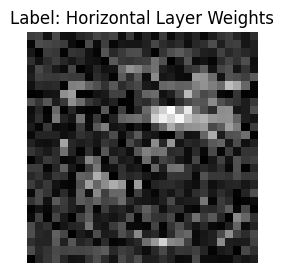

In [60]:
visualize_image(horizontal_layer_weights, "Horizontal Layer Weights")

In [61]:
vertical_layer_weights = np.abs(model.vertical_layer.weight[0].reshape(28, 28).detach().cpu().numpy())

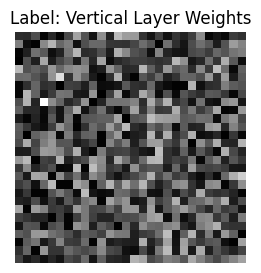

In [62]:
visualize_image(vertical_layer_weights, "Vertical Layer Weights")

In [63]:
classification_layer_weights = np.abs(model.classification_layer.weight[0].reshape(28, 28).detach().cpu().numpy())

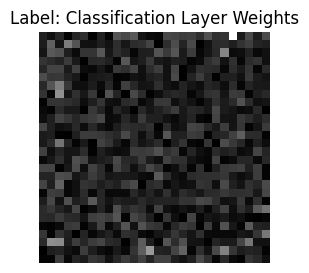

In [64]:
visualize_image(classification_layer_weights, "Classification Layer Weights")